# Monte Carlo 

In [69]:
import sys
!{sys.executable} -m pip install astropy
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scipy
import scipy.stats as st
from scipy import optimize
from astropy.io import fits
from astropy.table import Table
from scipy import interpolate
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision = 40, suppress = True) #prevents scientific notation for 40 character numbers

In [2]:
### Read in data file


GSample = fits.open('/Users/edm/Desktop/100pc_rvnotnull-Matched-Best.fits')
GSample_A = Table(GSample[1].data)

In [3]:
## print length of table

len(GSample_A)

167020

In [4]:
## take a look at columns

GSample_A

<Table length=167020>
    SOURCE_ID_1            RA_1         RA_ERROR_1 ... teff_gspphot   vbroad 
       int64             float64         float64   ...   float32     float32 
------------------- ------------------ ----------- ... ------------ ---------
5853498713190525696 217.39232147200883 0.023999203 ...    2829.3542       nan
4472832130942575872 269.44850252543836 0.026238997 ...    3099.6335       nan
 762815470562110464 165.83095967577933 0.024125582 ...     3511.045 10.002441
4075141768785646848  282.4587890175222 0.029065154 ...     3117.376       nan
1926461164913660160  355.4800152581559  0.03218242 ...          nan       nan
6553614253923452800  346.5039166796005 0.017067203 ...    3376.0845  5.767302
1872046574983497216   316.753662752556 0.018972972 ...    3889.6328 6.9816794
1872046609345556480  316.7484792940004  0.03876041 ...    4353.7437 5.7024636
2154880616774131840  280.6830708352289 0.021600218 ...     3352.192       nan
2154880616774131712 280.68308624583415 0.030707553 ...    3179.6333       nan
                ...                ...         ... ...          ...       ...
4072503039634788736  280.0046318198612 0.015781714 ...     3620.593       nan
1997756625600681600 353.09671688774444 0.015836248 ...    3491.9302       nan
4191162991637325824  302.3955216980271 0.014745331 ...     5205.402       nan
5761035592009134848 132.65107615466013 0.046826992 ...          nan 20.349188
5055343362578489344 53.619121006456545 0.015574422 ...    3470.5942       nan
1407928457594520576 253.50218132917882   0.0172391 ...    3491.9934       nan
6832879006104020096 318.17681412703587  0.02378706 ...    3551.0818       nan
  71475475647268736  55.05770921046282 0.041410603 ...    3442.6294       nan
 473881441333817984  60.74761405694887 0.010009908 ...    5576.3228       nan
 518180210764160512  30.15544146978542 0.008064788 ...     3871.986       nan

In [5]:
## pull out variables on interest

#radial velocity
Rvel = np.asarray(GSample_A["radial_velocity"])
rv=Rvel

ra = np.asarray(GSample_A["ra_2"])
dec = np.asarray(GSample_A["dec_2"])

rv_e = np.asarray(GSample_A["radial_velocity_error"]) 


# PM RA and Dec
PMD = np.asarray(GSample_A['PMDEC_1'])
PMR = np.asarray(GSample_A['PMRA_1'])
PMR_e = np.asarray(GSample_A['PMRA_ERROR_1'])
PMD_e = np.asarray(GSample_A['PMDEC_ERROR_1'])



#parallax
plx = np.asarray(GSample_A['PARALLAX_1'])
plx_e = np.asarray(GSample_A['PARALLAX_ERROR_1'])

#median distanc

## read in temperature
teff=np.asarray(GSample_A['teff_gspphot'])

## temperature has no error
Bp_Rp = np.asarray(GSample_A['PHOT_BP_MEAN_MAG_1']) - np.asarray(GSample_A['PHOT_RP_MEAN_MAG_1'])

source_id = np.asarray(GSample_A["source_id_2"])

## read in mags
phot_bp_mean_mag = np.asarray(GSample_A['PHOT_BP_MEAN_MAG_1'])
phot_bp_mean_mag_err = np.asarray(1/GSample_A['PHOT_BP_MEAN_FLUX_OVER_ERROR_1']) * phot_bp_mean_mag

phot_rp_mean_mag = np.asarray(GSample_A['PHOT_RP_MEAN_MAG_1'])
phot_rp_mean_mag_err = np.asarray(1/GSample_A['PHOT_RP_MEAN_FLUX_OVER_ERROR_1']) * phot_rp_mean_mag


In [205]:
### Create arrays for everything
npts        = 500
rv_array    = np.zeros((len(GSample_A),npts))
pmra_array  = rv_array*0
pmdec_array = rv_array*0
plx_array   = rv_array*0
bp_array    = rv_array*0
rp_array    = rv_array*0

#creates empty arrays for every variable
med_rv2 = []
med_plx2 = []
med_pmra2 = []
med_pmdec2 = []
med_bp2 = []
med_rp2 = []
med_bprp2 = []

#creates empty arrays for low medians 
low_rv2 = []
low_plx2 = []
low_pmra2 = []
low_pmdec2 = []
low_bp2 = []
low_rp2 = []
low_bprp2 = []

#creates empty arrays for high medians
h_rv2 = []
h_plx2 = []
h_pmra2 = []
h_pmdec2 = []
h_bp2 = []
h_rp2 = []
h_bprp2 = []

#creates a loop that uses a random sample (using errors) then calculates the median for everything before inputting
#them into the newly created arrays
for i in range(0,len(GSample_A)):
    rv_array[i,:] = np.random.normal(rv[i],rv_e[i],npts)
    pmra_array[i,:] = np.random.normal(PMR[i],PMR_e[i],npts)
    pmdec_array[i,:] = np.random.normal(PMD[i],PMD_e[i],npts)
    plx_array[i,:] = np.random.normal(plx[i],plx_e[i],npts)
    bp_array[i,:] = np.random.normal(phot_bp_mean_mag[i],phot_bp_mean_mag_err[i],npts)
    rp_array[i,:] = np.random.normal(phot_rp_mean_mag[i],phot_rp_mean_mag_err[i],npts)
    
    med_rv1 = np.median(rv_array[i,:])
    med_plx1 = np.median(plx_array[i,:])
    med_pmra1 = np.median(pmra_array[i,:])
    med_pmdec1 = np.median(pmdec_array[i,:])
    med_bp1 = np.median(bp_array[i,:])
    med_rp1 = np.median(rp_array[i,:])
    med_bprp1 = med_bp1 - med_rp1
    
    low_rv1 = np.quantile(rv_array[i,:], .05)
    low_plx1 = np.quantile(plx_array[i,:], .05)
    low_pmra1 = np.quantile(pmra_array[i,:], .05)
    low_pmdec1 = np.quantile(pmdec_array[i,:], .05)
    low_bp1 = np.quantile(bp_array[i,:], .05)
    low_rp1 = np.quantile(rp_array[i,:], .05)
    low_bprp1 = np.quantile((bp_array[i,:] - rp_array[i,:]), .05)
    
    h_rv1 = np.quantile(rv_array[i,:], .95)
    h_plx1 = np.quantile(plx_array[i,:],.95)
    h_pmra1 = np.quantile(pmra_array[i,:], .95)
    h_pmdec1 = np.quantile(pmdec_array[i,:], .95)
    h_bp1 = np.quantile(bp_array[i,:], .95)
    h_rp1 = np.quantile(rp_array[i,:], .95)
    h_bprp1 = np.quantile((bp_array[i,:] - rp_array[i,:]), .95)
    
    med_rv2.append(med_rv1)
    med_plx2.append(med_plx1)
    med_pmra2.append(med_pmra1)
    med_pmdec2.append(med_pmdec1)
    med_bp2.append(med_bp1)
    med_rp2.append(med_rp1)
    med_bprp2.append(med_bprp1)
    
    low_rv2.append(low_rv1)
    low_plx2.append(low_plx1)
    low_pmra2.append(low_pmra1)
    low_pmdec2.append(low_pmdec1)
    low_bp2.append(low_bp1)
    low_rp2.append(low_rp1)
    low_bprp2.append(low_bprp1)
    
    h_rv2.append(h_rv1)
    h_plx2.append(h_plx1)
    h_pmra2.append(h_pmra1)
    h_pmdec2.append(h_pmdec1)
    h_bp2.append(h_bp1)
    h_rp2.append(h_rp1)
    h_bprp2.append(h_bprp1)
    
med_rv = np.hstack(med_rv2)
med_plx = np.hstack(med_plx2)
med_pmra = np.hstack(med_pmra2)
med_pmdec = np.hstack(med_pmdec2)
med_bp = np.hstack(med_bp2)
med_rp = np.hstack(med_rp2)
med_bprp = np.hstack(med_bprp2)

low_rv = np.hstack(low_rv2)
low_plx = np.hstack(low_plx2)
low_pmra = np.hstack(low_pmra2)
low_pmdec = np.hstack(low_pmdec2)
low_bp = np.hstack(low_bp2)
low_rp = np.hstack(low_rp2)
low_bprp = np.hstack(low_bprp2)

h_rv = np.hstack(h_rv2)
h_plx = np.hstack(h_plx2)
h_pmra = np.hstack(h_pmra2)
h_pmdec = np.hstack(h_pmdec2)
h_bp = np.hstack(h_bp2)
h_rp = np.hstack(h_rp2)
h_bprp = np.hstack(h_bprp2)

#period_dist = np.random.normal(period, period_e, 10000)


In [206]:
#uses new median values for the arrays
med_pmtot_array = np.sqrt(med_pmra**2+med_pmdec**2)
med_vtan_array = (4.74/med_plx)*med_pmtot_array
med_vtot_array = (np.sqrt(med_vtan_array**2+med_rv**2))
c1 = 0.9779*10**9
c2 = 4.74047

In [207]:
t = (-c1*(1/med_plx)*(med_rv/med_vtot_array**2))/10**6
d = 10**3*(1/med_plx)*(med_vtan_array/med_vtot_array)

In [208]:
#uses new median values for the arrays
lmed_pmtot_array = np.sqrt(low_pmra**2+low_pmdec**2)
lmed_vtan_array = (4.74/low_plx)*low_pmtot_array
lmed_vtot_array = (np.sqrt(lmed_vtan_array**2+low_rv**2))
c1 = 0.9779*10**9
c2 = 4.74047

In [209]:
lt = (-c1*(1/low_plx)*(low_rv/lmed_vtot_array**2))/10**6
ld = 10**3*(1/low_plx)*(lmed_vtan_array/lmed_vtot_array)

In [210]:
#uses new median values for the arrays
hmed_pmtot_array = np.sqrt(h_pmra**2+h_pmdec**2)
hmed_vtan_array = (4.74/h_plx)*hmed_pmtot_array
hmed_vtot_array = (np.sqrt(hmed_vtan_array**2+h_rv**2))
c1 = 0.9779*10**9
c2 = 4.74047

In [211]:
ht = (-c1*(1/h_plx)*(h_rv/hmed_vtot_array**2))/10**6
hd = 10**3*(1/h_plx)*(hmed_vtan_array/hmed_vtot_array)

Text(0.5, 0, 'Rp')

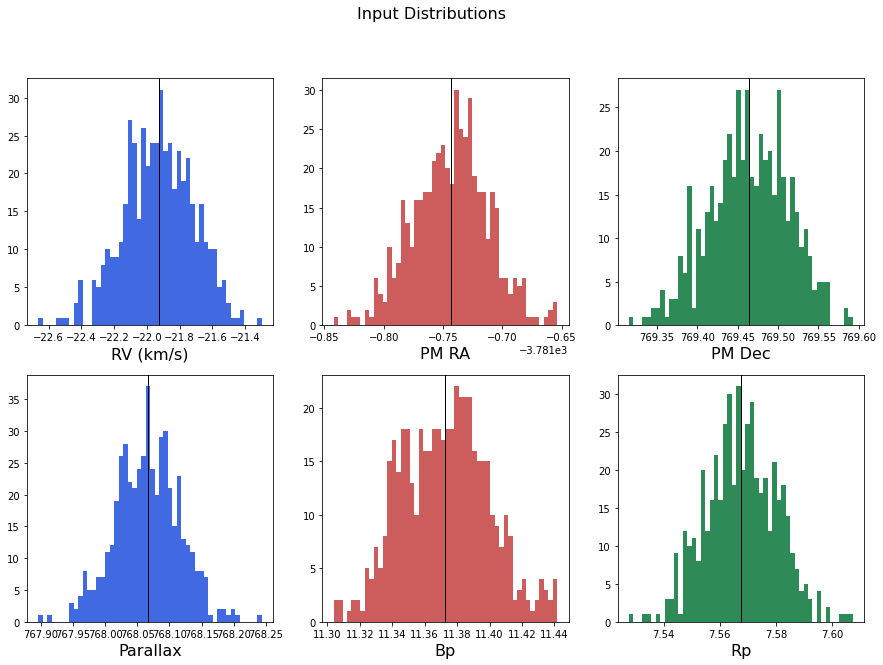

In [9]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))

#shows a distribution of the rv, pmra, ppmdec, plx, and bprp
fig.suptitle('Input Distributions', fontsize=16)
ax1.hist(rv_array[0,:],bins=50,color='royalblue')
ax2.hist(pmra_array[0,:],bins=50,color='indianred')
ax3.hist(pmdec_array[0,:],bins=50,color='seagreen')
ax4.hist(plx_array[0,:],bins=50,color='royalblue')
ax5.hist(bp_array[0,:],bins=50,color='indianred')
ax6.hist(rp_array[0,:],bins=50,color='seagreen')

#plots the mean along the xaxis 
ax1.axvline(rv_array[0,:].mean(), color='black', linestyle='solid', linewidth=1)
ax2.axvline(pmra_array[0,:].mean(), color='black', linestyle='solid', linewidth=1)
ax3.axvline(pmdec_array[0,:].mean(), color='black', linestyle='solid', linewidth=1)
ax4.axvline(plx_array[0,:].mean(), color='black', linestyle='solid', linewidth=1)
ax5.axvline(bp_array[0,:].mean(), color='black', linestyle='solid', linewidth=1)
ax6.axvline(rp_array[0,:].mean(), color='black', linestyle='solid', linewidth=1)

#labels the axis
ax1.set_xlabel('RV (km/s)', fontsize=16)
ax2.set_xlabel('PM RA', fontsize=16)
ax3.set_xlabel('PM Dec', fontsize=16)
ax4.set_xlabel('Parallax', fontsize=16)
ax5.set_xlabel('Bp', fontsize=16)
ax6.set_xlabel('Rp', fontsize=16)




In [10]:
def value(s):
    try:
        return float(s)
    except ValueError:
        return 0

In [11]:
## Read in Bp-Rp from Mamajek file.
M_bprp = np.loadtxt('/Users/edm/Desktop/Gaia Data/EEM_dwarf_UBVIJHK_colors_Teff.txt', usecols=(11), comments='#', dtype='str',  converters={11: value})
M_bprp = M_bprp.astype('float64')
print(len(M_bprp))

## read in mass from Mamajek file
M_mass = np.loadtxt('/Users/edm/Desktop/Gaia Data/EEM_dwarf_UBVIJHK_colors_Teff.txt',usecols=(30), comments='#',dtype='str',  converters={30: value})
M_mass = M_mass.astype('float64')
print(len(M_mass))

## read in teff from Mamajek file
M_teff = np.loadtxt('/Users/edm/Desktop/Gaia Data/EEM_dwarf_UBVIJHK_colors_Teff.txt',usecols=(1), comments='#',dtype='str',  converters={1: value})
M_teff = M_teff.astype('float64')
print(len(M_teff))


118
118
118


In [12]:
M_mass=M_mass[6:87]
M_teff=M_teff[6:87]
M_bprp=M_bprp[6:87]

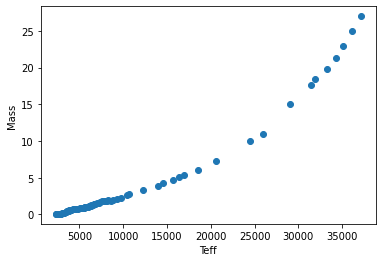

In [13]:
#concatanating 1d arrays code does not iterate over float
#scatter = plt.scatter(new_data2,new_data)

scatter = plt.scatter(M_teff,M_mass)
plt.xlabel('Teff')
plt.ylabel('Mass')
plt.show()




Text(0, 0.5, 'Teff')

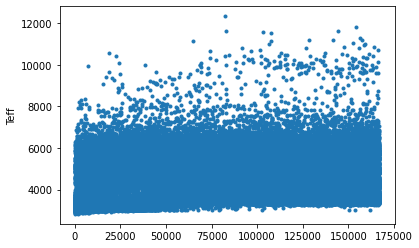

In [14]:
## plot Gaia teff values to understand their range etc.

plt.plot(teff,marker='.',linestyle='None')
plt.ylabel('Teff')

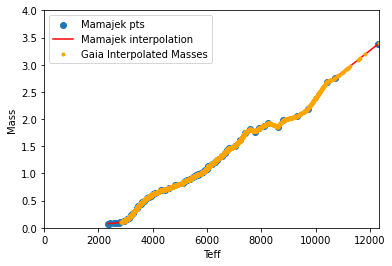

In [15]:
## use interpolation to figure out the match between T and M

f = interpolate.interp1d(M_teff,M_mass)
#top_press_P1 - top_press_P2


#xnew = np.log10(top_press_P1)
new_mass=f(M_teff)


scatter = plt.scatter(M_teff,M_mass,label='Mamajek pts')
plt.plot(M_teff,f(M_teff),color='red',label='Mamajek interpolation')
plt.plot(teff,f(teff),color='orange',label='Gaia Interpolated Masses',linestyle='None',marker='.')
plt.xlabel('Teff')
plt.ylabel('Mass')
plt.legend()
plt.ylim(0,4)
plt.xlim(0,max(teff))
plt.show()



In [16]:
## use interpolated function to calculate masses from temperatures:
Mass = f(teff)

In [17]:
## Gliese 710 doesn't have a teff, so therefore the mass
G710 = np.where(source_id==4270814637616488064)


print(Mass[G710])
print(teff[G710])
print((Bp_Rp[G710]))
#print(Bp_Rp.shape)

[nan]
[nan]
[1.6937250000000006]


In [18]:
print(np.count_nonzero(np.isnan(Mass)))

print(np.count_nonzero(np.isnan((Bp_Rp))))

## ok there are a lot of nans!!! for objects with nan Teff values, use Bp_Rp to calculate Mass



73613
1513


In [19]:
## have to trim arrays again because BP_Rp has zeros at beginning

M_bprp=M_bprp[18:]
M_teff=M_teff[18:]
M_mass=M_mass[18:]

nans = np.where(np.isnan(teff))

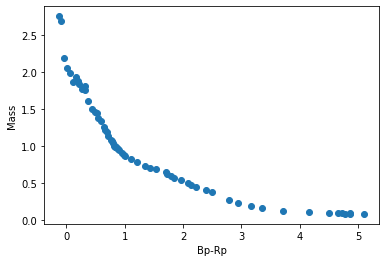

2.75


In [20]:
### do the same interpolation with Bp_Rp for objects with nans:

scatter = plt.scatter(M_bprp,M_mass)
plt.xlabel('Bp-Rp')
plt.ylabel('Mass')
plt.show()

print(max(M_mass))


In [21]:
#interpolation will only work where Bp_Rp is within range of Mamajek values, so remove any

print(min(Bp_Rp))
print(min(M_bprp))



nans_bprp = np.where((np.isnan(teff)) & (Bp_Rp > min(M_bprp)))
#print(nans_bprp)

-0.47897249999999936
-0.12


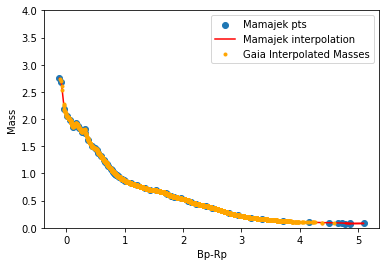

In [22]:
## use interpolation to figure out the match between T and M

f2 = interpolate.interp1d(M_bprp,M_mass)
#top_press_P1 - top_press_P2


#xnew = np.log10(top_press_P1)
#new_mass=f2(M_bprp)


scatter = plt.scatter(M_bprp,M_mass,label='Mamajek pts')
plt.plot(M_bprp,f2(M_bprp),color='red',label='Mamajek interpolation')
plt.plot(Bp_Rp[nans_bprp],f2(Bp_Rp[nans_bprp]),color='orange',label='Gaia Interpolated Masses',linestyle='None',marker='.')
plt.xlabel('Bp-Rp')
plt.ylabel('Mass')
plt.legend()
plt.ylim(0,4)
#plt.xlim(0,max(bprp))
plt.show()





Mass[nans_bprp] = f2(Bp_Rp[nans_bprp])



In [121]:
## How many objects without masses are left???

print(np.count_nonzero(np.isnan(Mass)))
print(Mass[G710])

1515
[0.6418455882352939]


In [143]:
med_t = -c1*(1/med_plx)*(med_rv/med_vtot_array**2)
med_d = 10**3*(1/med_plx)*(med_vtan_array/med_vtot_array)

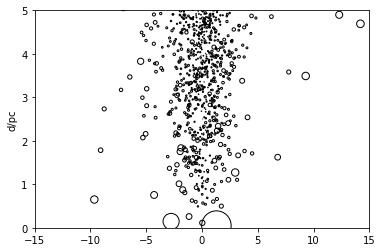

In [144]:
area = (Mass)/(med_d*med_vtot_array)
plt.scatter(med_t/10**6, med_d, s = 1000*area, facecolor = 'none', edgecolor = 'black')

xmin, xmax = plt.xlim(-15,15)
ymin, ymax = plt.ylim(0,5)

#plt.xlabel("t/Myr")
plt.ylabel("d/pc")
plt.show()

In [145]:
d[1561]

0.05116479712618395

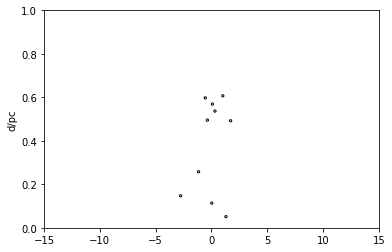

In [243]:

plt.scatter(t[np.argsort(d)[0:10]], d[np.argsort(d)[0:10]], s = 5, facecolor = 'none', edgecolor = 'black')
#plt.errorbar(t[np.argsort(d)[0:25]],d[np.argsort(d)[0:25]], [ld[np.argsort(d)[0:25]], hd[np.argsort(d)[0:25]]],ecolor='b', fmt='ko', markersize = 2)

#xerr = [lt[np.argsort(ld)[0:10]], ht[np.argsort(hd)[0:10]]]
#yerr = [ld[np.argsort(ld)[0:10]], hd[np.argsort(hd)[0:10]]]
#plt.errorbar(t[np.argsort(d)[0:10]], d[np.argsort(d)[0:10]], yerr, xerr, fmt='ko', markersize = 2)


xmin, xmax = plt.xlim(-15,15)
ymin, ymax = plt.ylim(0,1)

#plt.xlabel("t/Myr")
plt.ylabel("d/pc")
plt.show()

In [213]:
d[1561] - ld[1561]

0.046233695997463325

In [214]:
d[1561] + hd[1561]

0.09868764677270883

In [215]:
d[1561]

0.051252034483139475

In [232]:
ht[1561]

1.3294279555806654

In [233]:
lt[1561]

1.2592408919483464

In [234]:
t[1561]

1.2951784823073451

In [28]:
# This is a white dwarf whose RV needs to be corrected -- I have hard-coded 39.4 value. 
# Should update this! Via: 

# calculation here: https://www.wolframalpha.com/input?i=%28speed+of+light%29*%28%281-2*%28gravitational+constant%29*%280.7*%28mass+of+the+Sun%29%29%2F%28%281.234*%28radius+of+the+Earth%29%29*%28speed+of+light%29%5E2%29%29%5E%28-1%2F2%29-1%29

# and Here’s how I got the radius from log g and mass:
#https://www.wolframalpha.com/input?i=sqrt%280.7*%28mass+of+the+Sun%29%2F%28%2810%5E%288.177%29++centimeters%2Fsecond%5E2%29%2F%28gravitational+constant%29%29%29%2F%28radius+of+the+Earth%29

object_of_interest = np.where(source_id==5544743925212648320)
rv_array[object_of_interest,:] = rv_array[object_of_interest,:] - 39.4

## sanity check that this worked

print(np.median(rv_array[object_of_interest,:]))

-413.23567444301693


In [29]:
#y = (20.38*np.exp(-2.92*Bp_Rp) + .48)
#np.asarray(y)
#Mass = y

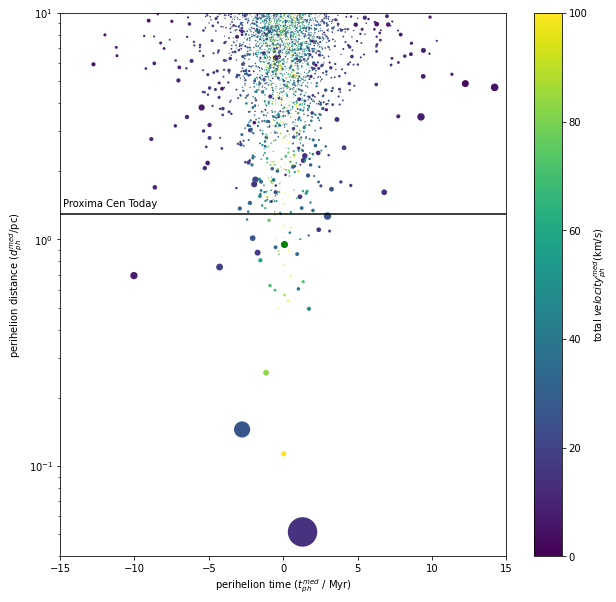

In [30]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 10))

area = (Mass)/(med_d*med_vtot_array)

plt.scatter(med_t/10**6, med_d, s = 1000*area, alpha = 1, edgecolor = 'none', facecolor = 'none', c = med_vtot_array, vmin=0, vmax=100, cmap='viridis')
#plt.scatter(t[0]/10**6, d[0], s = 1000*area[0], alpha = 1, edgecolor = 'none', facecolor = 'none', c = 'green')
plt.plot(med_t[0]/10**6, med_d[0],marker='o',color='green')
plt.plot(np.arange(-20,20,1), np.zeros(40)+1.3,color='black')
plt.text(-14.8,1.4,'Proxima Cen Today')
cbartitle = plt.colorbar()
cbartitle.set_label('total $velocity^{med}_{ph}$(km/s)')
#plt.scatter(tph/10**3, dph, s = 500*area, alpha = .5, edgecolor = 'black', facecolor = 'black', marker = 'x')
xmin, xmax = plt.xlim(-15,15)
ymin, ymax = plt.ylim(0.04,10)
plt.xlabel("perihelion time ($t^{med}_{ph}$ / Myr)")
plt.ylabel("perihelion distance ($d^{med}_{ph}$/pc)")
plt.yscale('log')


# current top 10 stars on plot now.
# 


In [31]:
### set up arrays for closest 10 objects now
t[np.argsort(-1*med_plx)[i]]/10**6
1/(med_plx[np.argsort(-1*med_plx)[i]]/1000)


print(med_d[np.argsort(-1*med_plx)[0:10]])
print('*************')
print(1/(med_plx[np.argsort(-1*med_plx)[0:10]]/1000))
print('*************')

print(med_t[np.argsort(-1*med_plx)[0:10]])



print(min(rv))
print(max(rv))
#d[np.argsort(-1*parallax)[0:10]]

[0.957900410126536  1.1553636451213731 1.4349426611152298
 1.9270263674568102 0.9332615461027154 3.2782437685799417
 2.7936390412992798 2.792419183395477  3.5209056197219284
 3.522257765565284 ]
*************
[1.3019709407785232 1.828239267474524  2.5461306265544335
 2.9759562827618535 3.159710579307806  3.28803289077793
 3.496404943948551  3.4966447728911265 3.5230944153466717
 3.5231501974675123]
*************
[ 26637.8419017618      9721.899325279397   19961.176949142224
 152365.35696505473    36485.55955916309    -2300.111263806157
  19140.53080002476    18773.112158482014    3271.7651121974786
  -1992.169025837245 ]
-861.1135
795.8258


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


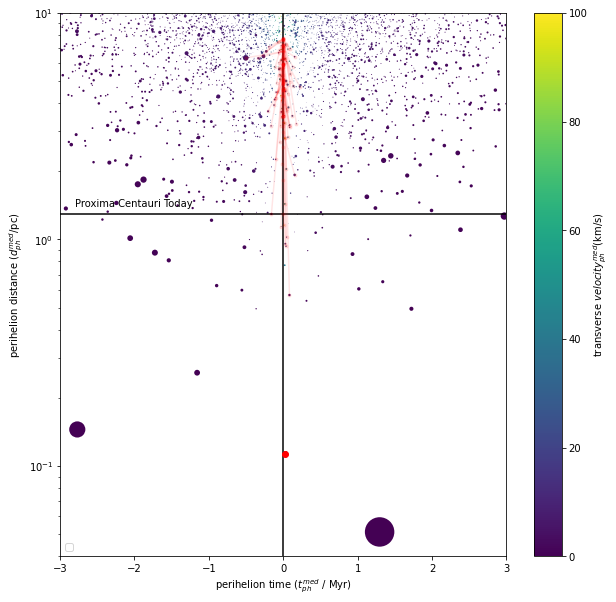

In [32]:
#### overplot an object of interest if you know the Gaia DR3 ID

#object_of_interest = np.where(source_id==5853498713190525696)

plt.figure(figsize=(10, 10))

area = (Mass)/(med_d*med_vtot_array)

plt.plot(np.arange(-20,20,1), np.zeros(40)+1.3,color='black')
plt.plot(np.zeros(100), np.arange(0,100),color='black')

plt.scatter(med_t/10**6, med_d, s = 1000*area, alpha = 1, edgecolor = 'none', facecolor = 'none', c = med_vtan_array, vmin=0, vmax=100, cmap='viridis')
#plt.scatter(t[0]/10**6, d[0], s = 1000*area[0], alpha = 1, edgecolor = 'none', facecolor = 'none', c = 'green')
plt.plot(med_t[object_of_interest]/10**6, med_d[object_of_interest],marker='o',color='red')


plt.text(-2.8,1.4,'Proxima Centauri Today')

for i in range(0,100):
    plt.plot([0, med_t[np.argsort(-1*med_plx)[i]]/10**6], [1/(med_plx[np.argsort(-1*med_plx)[i]]/1000),med_d[np.argsort(-1*med_plx)[i]]],marker='.',color='red',alpha=0.1,linestyle='-')

    
  #  1/(parallax[np.argsort(-1*parallax)[0:10]]/1000)


cbartitle = plt.colorbar()
cbartitle.set_label('transverse $velocity^{med}_{ph}$(km/s)')
#plt.scatter(tph/10**3, dph, s = 500*area, alpha = .5, edgecolor = 'black', facecolor = 'black', marker = 'x')
xmin, xmax = plt.xlim(-3,3)
ymin, ymax = plt.ylim(0.04,10)
plt.xlabel("perihelion time ($t^{med}_{ph}$ / Myr)")
plt.ylabel("perihelion distance ($d^{med}_{ph}$/pc)")
plt.yscale('log')
#plt.xscale('log')
plt.legend()



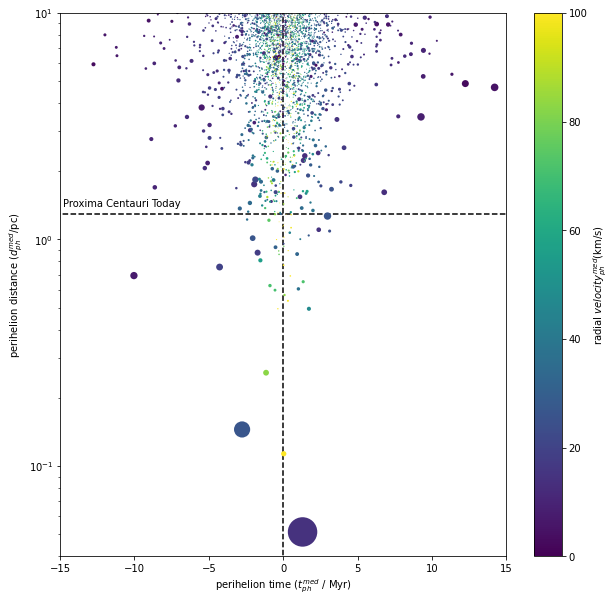

In [33]:
#### overplot an object of interest if you know the Gaia DR3 ID

#object_of_interest = np.where(source_id==5544743925212648320)

plt.figure(figsize=(10, 10))

area = (Mass)/(med_d*med_vtot_array)

plt.plot(np.arange(-20,20,1), np.zeros(40)+1.3,color='black',linestyle='dashed',zorder=0)
plt.plot(np.zeros(100), np.arange(0,100),color='black',linestyle='dashed',zorder=0)

plt.scatter(med_t/10**6, med_d, s = 1000*area, alpha = 1, edgecolor = 'none', facecolor = 'none', c = np.abs(rv), vmin=0, vmax=100, cmap='viridis')
#plt.scatter(t[0]/10**6, d[0], s = 1000*area[0], alpha = 1, edgecolor = 'none', facecolor = 'none', c = 'green')
#plt.plot(t[object_of_interest]/10**6, d[object_of_interest],marker='o',color='red')


plt.text(-14.8,1.4,'Proxima Centauri Today')

#for i in range(0,5000):
#    plt.plot([0, t[np.argsort(-1*parallax)[i]]/10**6], [1/(parallax[np.argsort(-1*parallax)[i]]/1000),d[np.argsort(-1*parallax)[i]]],marker='.',color='red',alpha=0.1,linestyle='-')

#plt.plot([0, t[np.argsort(-1*parallax)[object_of_interest]]/10**6], [1/(parallax[np.argsort(-1*parallax)[object_of_interest]]/1000),d[np.argsort(-1*parallax)[object_of_interest]]],marker='.',color='red',alpha=1,linestyle='-')

    
  #  1/(parallax[np.argsort(-1*parallax)[0:10]]/1000)


cbartitle = plt.colorbar()
cbartitle.set_label('radial $velocity^{med}_{ph}$(km/s)')
#plt.scatter(tph/10**3, dph, s = 500*area, alpha = .5, edgecolor = 'black', facecolor = 'black', marker = 'x')
xmin, xmax = plt.xlim(-15,15)
ymin, ymax = plt.ylim(0.04,10)
plt.xlabel("perihelion time ($t^{med}_{ph}$ / Myr)")
plt.ylabel("perihelion distance ($d^{med}_{ph}$/pc)")
plt.yscale('log')
#plt.xscale('log')
#plt.legend()

plt.savefig('DR3_StellarEncounters.png',dpi=300, facecolor='White')


In [34]:
med_d[object_of_interest]

array([0.11346628352092838])

In [35]:
#source_id = np.asarray(GSample_A["source_id_2"])
source_id[np.argsort(med_d)[0:10]]

array([4270814637616488064, 5544743925212648320,  510911618569239040,
       5571232118090082816, 3372104035275483392,  929788371508812288,
       4116451378388951424, 1952802469918554368, 3054509410098672000,
       3600338081985998080])

In [36]:
source_id[np.argsort(-1*area)[0:10]]

array([4270814637616488064,  510911618569239040, 3448410657639298048,
       3448457932341125248, 6150582597406438016, 4454410779977796736,
       4641579922816739072, 5469802896279029504, 5433129540632978688,
       4628931342912981504])

In [37]:
area[np.argsort(-1*area)[0:10]]

array([0.8682383114201899  , 0.26154892977812494 , 0.05795633708287979 ,
       0.05607210228770798 , 0.05607095978175694 , 0.05456866214910186 ,
       0.053489201953263725, 0.04916563734603805 , 0.046890800019560065,
       0.04542565325387224 ])

In [38]:
### load in mags for col-mag diagram

phot_g_mean_mag = np.asarray(GSample_A["phot_g_mean_mag_2"])
phot_bp_mean_mag = np.asarray(GSample_A["phot_bp_mean_mag_2"])
phot_rp_mean_mag = np.asarray(GSample_A["phot_rp_mean_mag_2"])
parallax = np.asarray(GSample_A["parallax_2"])


bp_rp = phot_bp_mean_mag - phot_rp_mean_mag
abs_mag = phot_g_mean_mag + 5*(np.log10(parallax))

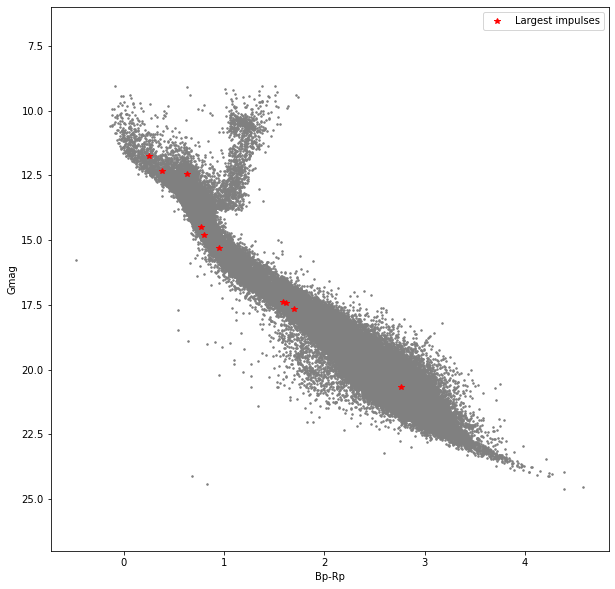

In [39]:
plt.figure(figsize=(10, 10))

plt.plot(bp_rp,abs_mag,linestyle='None',marker='.',markersize=3,color='grey')
plt.ylim(27,6)
plt.ylabel('Gmag')
plt.xlabel('Bp-Rp')

plt.plot(bp_rp[np.argsort(-1*area)[0:10]],abs_mag[np.argsort(-1*area)[0:10]],color='red',linestyle='None',marker='*' ,label='Largest impulses')

plt.legend()

plt.show()

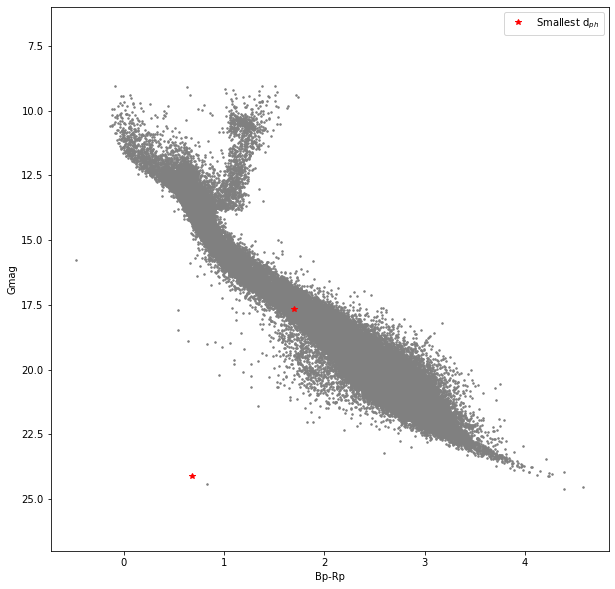

In [40]:
plt.figure(figsize=(10, 10))


plt.plot(bp_rp,abs_mag,linestyle='None',marker='.',markersize=3,color='grey')
plt.ylim(27,6)
plt.ylabel('Gmag')
plt.xlabel('Bp-Rp')

plt.plot(bp_rp[np.argsort(d)[0:2]],abs_mag[np.argsort(d)[0:2]],color='red',linestyle='None',marker='*' ,label='Smallest d$_{ph}$')

plt.legend()

plt.show()

In [41]:
source_id[np.argsort(med_d)[0:10]]

array([4270814637616488064, 5544743925212648320,  510911618569239040,
       5571232118090082816, 3372104035275483392,  929788371508812288,
       4116451378388951424, 1952802469918554368, 3054509410098672000,
       3600338081985998080])

In [58]:
sort_d = np.sort(d)
sort_d

array([ 0.05127799803262299,  0.11346628352092838,  0.14522109497550062,
        0.25844711718704355,  0.49474015431455814,  0.4949072442222616 ,
        0.5364659024083297 ,  0.568970837819469  ,  0.5978835421305733 ,
        0.6055335286859949 ,  0.6260783143274453 ,  0.6512232511765821 ,
        0.6907035470878379 ,  0.6930904164838526 ,  0.7559302633534395 ,
        0.7701431492314436 ,  0.8093019322703848 ,  0.8595729754608876 ,
        0.8624049776708917 ,  0.8748190902780788 ,  0.8903949982653234 ,
        0.8931501893753536 ,  0.9242886184834861 ,  0.9332615461027154 ,
        0.957900410126536  ,  0.9993932578523426 ,  1.003434608588231  ,
        1.0136417667290536 ,  1.0239563495788913 ,  1.041823175519424  ,
        1.0714676950756348 ,  1.079205052425509  ,  1.0894272332203316 ,
        1.1042782797721287 ,  1.1272666380359058 ,  1.1393886725408686 ,
        1.1553636451213731 ,  1.1724409561552582 ,  1.1963407041368068 ,
        1.2159382083746813 ,  1.2247575299710662 , 

In [59]:
np.where(source_id==3600338081985998080)

(array([12742]),)

In [64]:
proxima_cen = np.where(source_id==4270814637616488064)
proxima_cen

(array([1561]),)

In [43]:
med_d[1561]

0.05127799803262299

In [ ]:
### 1.234 earth radii == white dwarf radii

